# American Options

The aim of this notebook is to give some exaples of pricing American options.

Pricing American Options is essentially an optimal stopping problem.

\begin{aligned}
\text{maximize} \quad & E R_\tau\\
\text{subject to} \quad & \tau \in \mathcal{T}\\
\end{aligned}

where $R_t$ is the payoff at time $t$.

This can't be solved with Monte Carlo methods when written like this, because we don't know the stopping time $\tau$.

But we can rewrite the problem as

$$ \underset{M \in \mathcal{R_m}}{\inf}\ E[\underset{t \in [0,T]}{\sup} (R_t + M_T - M_t)] $$

where $\mathcal{R_m}$ is the space of continous adapted martingales $M$ for which $$ \{M_\tau | \tau \in \mathcal{T}\} $$ is uniformly integrable.

This reformulation is quite complicated and we will not go into the details here.

In our example we will use multiples of the discounted european put as the space of Martingales.

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [1]:
import fima
import numpy as np

import matplotlib.pyplot as plt

In [2]:
T = 0.5
K = 100
r = 0.06
sigma = 0.4

In [3]:
M = 10000

In [4]:
def discounted_american_put(S, t, K):
    return np.exp(-r * t) * np.maximum(K - S, 0)

In [5]:
def find_min(func, a, b, it):
    #finds the minimum of func on [a, b] using it iterations of the golden section search
    #returns the minimum and the value of func at the minimum
    
    c = (3 - np.sqrt(5))/2
    x1 = a + c*(b - a)
    x2 = b - c*(b - a)

    for i in range(it):
        if func(x1) < func(x2):
            b = x2
            x2 = x1
            x1 = a + c*(b - a)
        else:
            a = x1
            x1 = x2
            x2 = b - c*(b - a)

    return (a + b)/2, func((a + b)/2)

In [6]:
eta = np.random.normal(size = (int(T*1000),M))

In [7]:
def to_optimize(scalar, R, discounted_european_put_mt):
    sup = np.zeros(M)

    for i in range(M):
        sup[i] = np.max(R[:, i] + scalar*(discounted_european_put_mt[-1, i] - discounted_european_put_mt[:, i]))

    return np.mean(sup)

In [8]:
def american_put_price(x):
    S = fima.GBMpaths(x, r, sigma, T, eta)

    R = np.zeros((int(T*1000)+1, M))
    discounted_european_put_mt = np.zeros((int(T*1000) + 1, M))

    for i in range(int(T*1000)+1):
        R[i, :] = discounted_american_put(S[i, :], i/1000, K)
        discounted_european_put_mt[i, :] = np.exp(-r * i/1000) * fima.BS_put_price(i/1000, S[i, :], K, r, sigma, T)

    func = lambda scalar: to_optimize(scalar, R, discounted_european_put_mt)

    return find_min(func, 0, 2, 10)

In [9]:
x = [80, 85, 90, 95, 100, 105, 110, 115, 120]

american_prices = [american_put_price(i)[1] for i in x]

In [10]:
t = 0

In [11]:
european_prices = [fima.BS_put_price(t, i, K, r, sigma, T) for i in x]

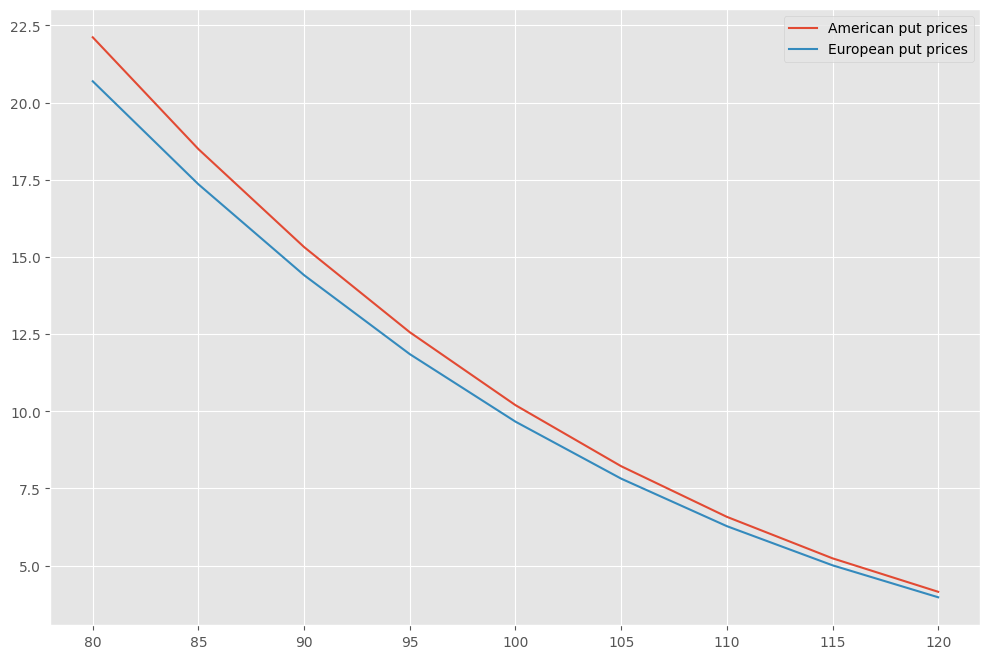

In [12]:
plt.plot(x, american_prices, label = 'American put prices')
plt.plot(x, european_prices, label = 'European put prices')
plt.legend();